
📊 Forecasting for stock_id: 50200
MSE: 0.00000035
QLIKE: -11.69525464
% within 10% error: 28.95%
Bias-Corrected MSE: 0.00000035
Bias-Corrected QLIKE: -11.69245087
Bias-Corrected % within 10% error: 28.83%


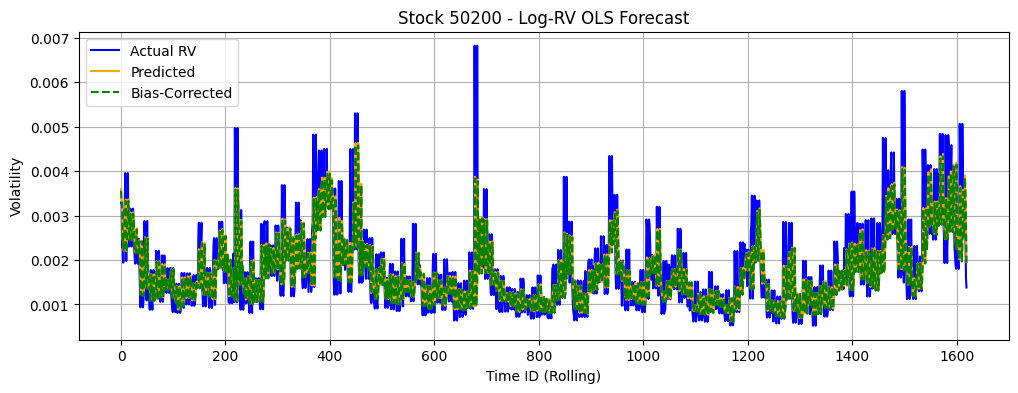


📊 Forecasting for stock_id: 104919
MSE: 0.00000065
QLIKE: -10.92611096
% within 10% error: 29.07%
Bias-Corrected MSE: 0.00000066
Bias-Corrected QLIKE: -10.92262482
Bias-Corrected % within 10% error: 28.46%


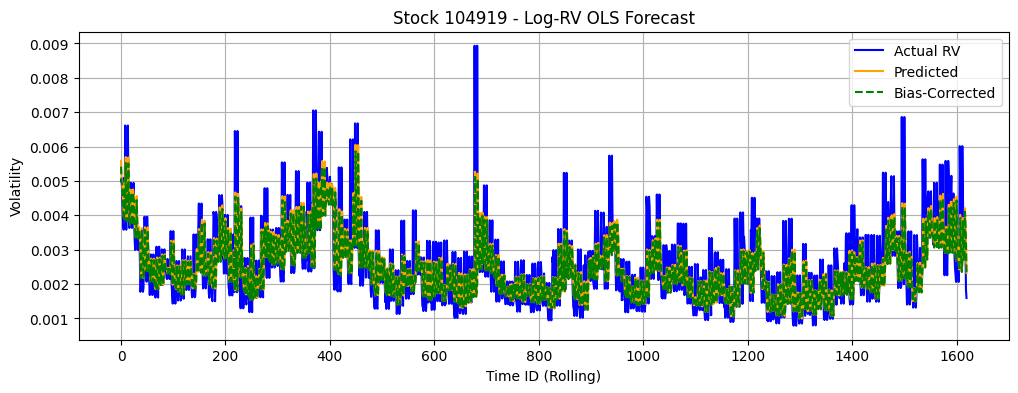

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import joblib

# Set global seed
np.random.seed(3888)

# === Global Config ===
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Load once
feature_df = pd.read_parquet(os.path.join(folder_path, "order_book_feature.parquet"), engine='pyarrow')
target_df = pd.read_parquet(os.path.join(folder_path, "order_book_target.parquet"), engine='pyarrow')
time_df = pd.read_csv(os.path.join(folder_path, "time_id_reference.csv"))
time_df["datetime"] = pd.to_datetime(time_df["date"] + " " + time_df["time"])

# Combine features and targets
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(["stock_id", "time_id", "seconds_in_bucket"]).reset_index(drop=True)

# === Helper Functions ===

def compute_features(df):
    df = df.copy()
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["wap"] = (df["bid_price1"] * df["ask_size1"] + df["ask_price1"] * df["bid_size1"]) / (df["ask_size1"] + df["bid_size1"])
    df["bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df["spread_pct"] = df["bid_ask_spread"] / df["mid_price"]
    df["imbalance"] = (df["bid_size1"] - df["ask_size1"]) / (df["bid_size1"] + df["ask_size1"])
    return df

def pct_within_tolerance(preds, actuals, tolerance=0.10):
    """Returns the percentage of predictions within a given relative error threshold."""
    within = np.abs(preds - actuals) / actuals < tolerance
    return np.mean(within) * 100

def run_log_rv_forecast(stock_id, plot=True, save_model=True):
    print(f"\n📊 Forecasting for stock_id: {stock_id}")

    # Filter and prepare data
    df = combined_df[combined_df["stock_id"] == stock_id].copy()
    df = compute_features(df)
    df = pd.merge(df, time_df[["time_id", "datetime"]], on="time_id", how="left")

    df["log_return"] = df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))
    rv_df = df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()
    rv_df["log_rv"] = np.log(rv_df["log_return"].clip(lower=1e-8))
    rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

    hav_df = rv_df.copy()
    for lag in [1, 5, 10]:
        hav_df[f"rv_lag_{lag}"] = hav_df["log_rv"].shift(lag)
    hav_df = hav_df.dropna().reset_index(drop=True)

    # Rolling window
    W, H, S = 330, 10, 5
    all_preds, all_actuals = [], []

    for start in range(0, len(hav_df) - W - H + 1, S):
        train = hav_df.iloc[start:start+W]
        test = hav_df.iloc[start+W:start+W+H]

        X_train = sm.add_constant(train[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
        y_train = train["log_rv"]
        X_test = sm.add_constant(test[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])

        model = sm.OLS(y_train, X_train).fit()
        all_preds.extend(model.predict(X_test))
        all_actuals.extend(test["log_rv"].values)

    # Back to RV
    preds = np.exp(np.array(all_preds))
    actuals = np.exp(np.array(all_actuals))

    mse = mean_squared_error(actuals, preds)
    qlike = np.mean(np.log(preds**2) + (actuals**2) / (preds**2))
    pct10 = pct_within_tolerance(preds, actuals)

    print(f"MSE: {mse:.8f}")
    print(f"QLIKE: {qlike:.8f}")
    print(f"% within 10% error: {pct10:.2f}%")

    # Bias correction
    reg = LinearRegression().fit(np.array(all_preds).reshape(-1, 1), all_actuals)
    corrected_log_preds = reg.predict(np.array(all_preds).reshape(-1, 1))
    corrected_preds = np.exp(corrected_log_preds)

    mse_corr = mean_squared_error(actuals, corrected_preds)
    qlike_corr = np.mean(np.log(corrected_preds**2) + (actuals**2) / (corrected_preds**2))
    pct10_corr = pct_within_tolerance(corrected_preds, actuals)

    print(f"Bias-Corrected MSE: {mse_corr:.8f}")
    print(f"Bias-Corrected QLIKE: {qlike_corr:.8f}")
    print(f"Bias-Corrected % within 10% error: {pct10_corr:.2f}%")

    # Plot
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(actuals, label="Actual RV", color="blue")
        plt.plot(preds, label="Predicted", color="orange")
        plt.plot(corrected_preds, label="Bias-Corrected", color="green", linestyle="--")
        plt.title(f"Stock {stock_id} - Log-RV OLS Forecast")
        plt.xlabel("Time ID (Rolling)")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Save model
    if save_model:
        X_full = sm.add_constant(hav_df[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
        y_full = hav_df["log_rv"]
        final_model = sm.OLS(y_full, X_full).fit()
        # joblib.dump(final_model, f"models/log_ols_model_{stock_id}.pkl")
        # print("💾 Model saved.")

    return {
        "stock_id": stock_id,
        "mse": mse,
        "qlike": qlike,
        "pct10": pct10,
        "mse_corr": mse_corr,
        "qlike_corr": qlike_corr,
        "pct10_corr": pct10_corr
    }

# === Run for multiple stocks ===
results_50200 = run_log_rv_forecast(stock_id=50200)
results_104919 = run_log_rv_forecast(stock_id=104919)



📊 Forecasting for stock_id: 104919
MSE: 0.00000065
QLIKE: -10.92611096
% within 10% error: 29.07%
Bias-Corrected MSE: 0.00000066
Bias-Corrected QLIKE: -10.92262482
Bias-Corrected % within 10% error: 28.46%


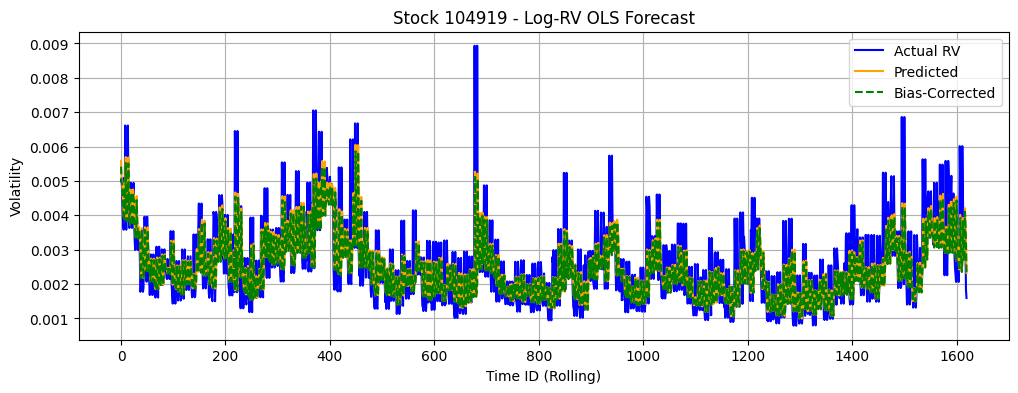


📊 Forecasting for stock_id: 50200
MSE: 0.00000035
QLIKE: -11.69525464
% within 10% error: 28.95%
Bias-Corrected MSE: 0.00000035
Bias-Corrected QLIKE: -11.69245087
Bias-Corrected % within 10% error: 28.83%


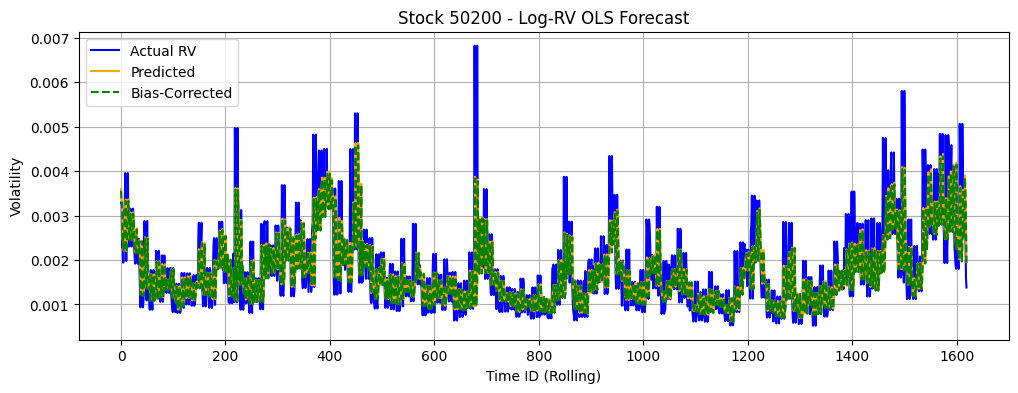

In [16]:
results = run_log_rv_forecast(stock_id=104919)
results = run_log_rv_forecast(stock_id=50200)


📊 Forecasting for stock_id: 50200 using RIDGE
 MSE: 0.00000035
QLIKE: -11.80088649
 % within 10% error: 33.46%


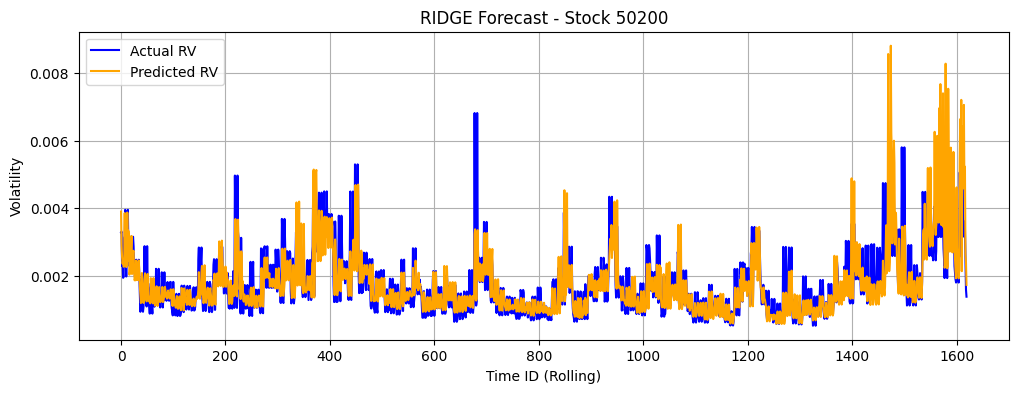


📊 Forecasting for stock_id: 50200 using LASSO
 MSE: 0.00000033
QLIKE: -11.80110352
 % within 10% error: 32.78%


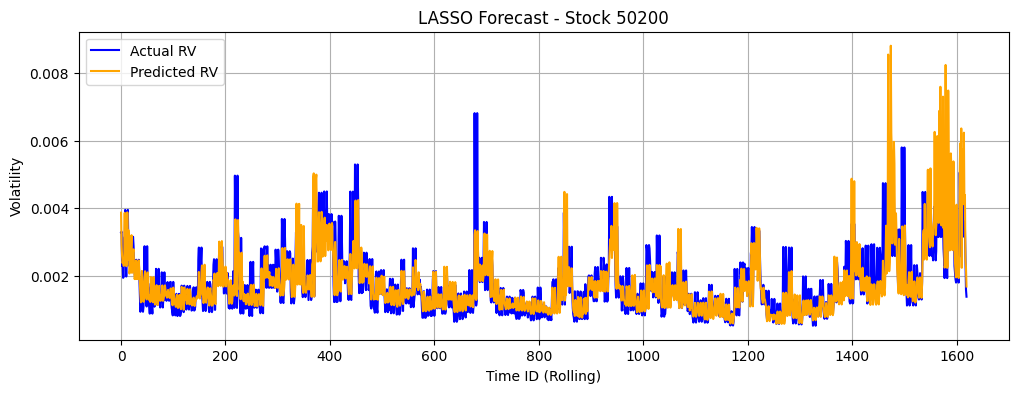

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

# Set global seed
np.random.seed(3888)

# === Global Config ===
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Load once
feature_df = pd.read_parquet(os.path.join(folder_path, "order_book_feature.parquet"), engine='pyarrow')
target_df = pd.read_parquet(os.path.join(folder_path, "order_book_target.parquet"), engine='pyarrow')
time_df = pd.read_csv(os.path.join(folder_path, "time_id_reference.csv"))
time_df["datetime"] = pd.to_datetime(time_df["date"] + " " + time_df["time"])

# Combine features and targets
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(["stock_id", "time_id", "seconds_in_bucket"]).reset_index(drop=True)

# === Helper Functions ===
def compute_features(df):
    df = df.copy()
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["wap"] = (df["bid_price1"] * df["ask_size1"] + df["ask_price1"] * df["bid_size1"]) / (df["ask_size1"] + df["bid_size1"])
    df["bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df["spread_pct"] = df["bid_ask_spread"] / df["mid_price"]
    df["imbalance"] = (df["bid_size1"] - df["ask_size1"]) / (df["bid_size1"] + df["ask_size1"])
    return df

def pct_within_tolerance(preds, actuals, tolerance=0.10):
    within = np.abs(preds - actuals) / actuals < tolerance
    return np.mean(within) * 100

def run_regularized_forecast(stock_id, model_type="ridge", plot=True):
    print(f"\n📊 Forecasting for stock_id: {stock_id} using {model_type.upper()}")

    df = combined_df[combined_df["stock_id"] == stock_id].copy()
    df = compute_features(df)
    df = pd.merge(df, time_df[["time_id", "datetime"]], on="time_id", how="left")

    df["log_return"] = df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))
    rv_df = df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()
    rv_df["log_rv"] = np.log(rv_df["log_return"].clip(lower=1e-8))
    rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

    hav_df = rv_df.copy()
    for lag in [1, 5, 10]:
        hav_df[f"rv_lag_{lag}"] = hav_df["log_rv"].shift(lag)

    # Extra predictive features
    agg_feats = df.groupby("time_id").agg({
        "spread_pct": "mean",
        "imbalance": "mean",
        "wap": "std"
    }).rename(columns={"wap": "wap_volatility"}).reset_index()

    hav_df = pd.merge(hav_df, agg_feats, on="time_id", how="left")
    hav_df = hav_df.dropna().reset_index(drop=True)

    features = ["rv_lag_1", "rv_lag_5", "rv_lag_10", "spread_pct", "imbalance", "wap_volatility"]
    scaler = StandardScaler()
    alphas = np.logspace(-4, 0, 50)

    W, H, S = 330, 10, 5
    all_preds, all_actuals = [], []

    for start in range(0, len(hav_df) - W - H + 1, S):
        train = hav_df.iloc[start:start+W]
        test = hav_df.iloc[start+W:start+W+H]

        X_train = scaler.fit_transform(train[features])
        X_test = scaler.transform(test[features])
        y_train = train["log_rv"]
        y_test = test["log_rv"]

        if model_type == "ridge":
            model = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)
        elif model_type == "lasso":
            model = LassoCV(alphas=alphas, cv=5, max_iter=10000).fit(X_train, y_train)
        else:
            raise ValueError("Invalid model_type. Use 'ridge' or 'lasso'.")

        pred_log = model.predict(X_test)
        all_preds.extend(pred_log)
        all_actuals.extend(y_test.values)

    preds = np.exp(np.array(all_preds))
    actuals = np.exp(np.array(all_actuals))

    mse = mean_squared_error(actuals, preds)
    qlike = np.mean(np.log(preds**2) + (actuals**2) / (preds**2))
    pct10 = pct_within_tolerance(preds, actuals)

    print(f" MSE: {mse:.8f}")
    print(f"QLIKE: {qlike:.8f}")
    print(f" % within 10% error: {pct10:.2f}%")


    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(actuals, label="Actual RV", color="blue")
        plt.plot(preds, label="Predicted RV", color="orange")
        plt.title(f"{model_type.upper()} Forecast - Stock {stock_id}")
        plt.xlabel("Time ID (Rolling)")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.show()

    return {
        "stock_id": stock_id,
        "model": model_type,
        "mse": mse,
        "qlike": qlike,
        "pct10": pct10
    }

# === Run ===
results_ridge = run_regularized_forecast(stock_id=50200, model_type="ridge")
results_lasso = run_regularized_forecast(stock_id=50200, model_type="lasso")




📊 Running Gamma Regression on stock_id 50200


/Users/dais/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/dais/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/dais/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/dais/Library/Python/3.9/lib/python/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/Users/dais/Library/Python/3.9/lib/p

 MSE: 0.00000060
 QLIKE: -11.73472537
% within 10% error: 27.65%


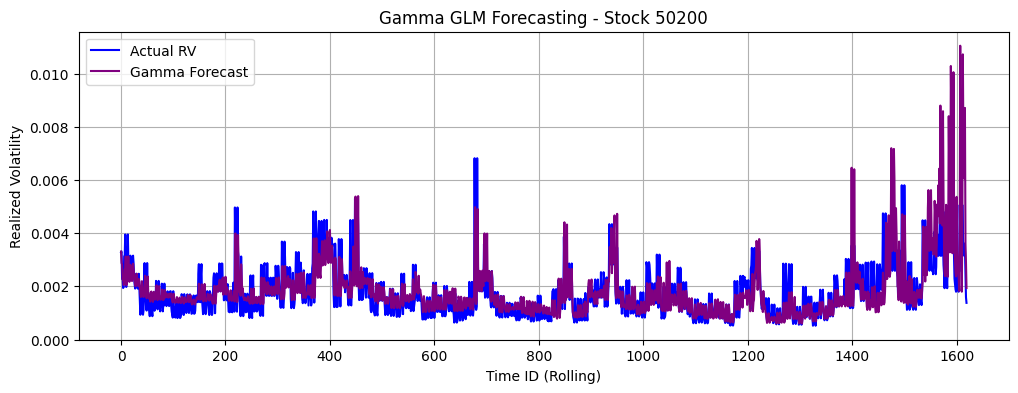

In [18]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Config
np.random.seed(3888)
folder_path = "/Users/dais/Downloads/Optiver_additional data"

# Load data
feature_df = pd.read_parquet(os.path.join(folder_path, "order_book_feature.parquet"))
target_df = pd.read_parquet(os.path.join(folder_path, "order_book_target.parquet"))
time_df = pd.read_csv(os.path.join(folder_path, "time_id_reference.csv"))
time_df["datetime"] = pd.to_datetime(time_df["date"] + " " + time_df["time"])
combined_df = pd.concat([feature_df, target_df], axis=0).sort_values(["stock_id", "time_id", "seconds_in_bucket"]).reset_index(drop=True)

def compute_features(df):
    df = df.copy()
    df["mid_price"] = (df["bid_price1"] + df["ask_price1"]) / 2
    df["wap"] = (df["bid_price1"] * df["ask_size1"] + df["ask_price1"] * df["bid_size1"]) / (df["ask_size1"] + df["bid_size1"])
    df["bid_ask_spread"] = df["ask_price1"] - df["bid_price1"]
    df["spread_pct"] = df["bid_ask_spread"] / df["mid_price"]
    df["imbalance"] = (df["bid_size1"] - df["ask_size1"]) / (df["bid_size1"] + df["ask_size1"])
    return df

def pct_within_tolerance(preds, actuals, tolerance=0.10):
    return np.mean(np.abs(preds - actuals) / actuals < tolerance) * 100

def run_gamma_forecast(stock_id, plot=True):
    print(f"\n📊 Running Gamma Regression on stock_id {stock_id}")
    df = combined_df[combined_df["stock_id"] == stock_id].copy()
    df = compute_features(df)
    df = pd.merge(df, time_df[["time_id", "datetime"]], on="time_id", how="left")

    df["log_return"] = df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))
    rv_df = df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()
    rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

    # Lagged and engineered features
    for lag in [1, 5, 10]:
        rv_df[f"rv_lag_{lag}"] = rv_df["realized_volatility"].shift(lag)

    agg_feats = df.groupby("time_id")[["spread_pct", "imbalance"]].mean().reset_index()
    rv_df = pd.merge(rv_df, agg_feats, on="time_id", how="left")
    rv_df = rv_df.dropna().reset_index(drop=True)

    features = ["rv_lag_1", "rv_lag_5", "rv_lag_10", "spread_pct", "imbalance"]

    # Rolling window
    W, H, S = 330, 10, 5
    all_preds, all_actuals = [], []

    for start in range(0, len(rv_df) - W - H + 1, S):
        train = rv_df.iloc[start:start+W]
        test = rv_df.iloc[start+W:start+W+H]

        X_train = sm.add_constant(train[features])
        y_train = train["realized_volatility"]
        X_test = sm.add_constant(test[features])
        y_test = test["realized_volatility"]

        model = sm.GLM(y_train, X_train, family=sm.families.Gamma(link=sm.families.links.log())).fit()
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_actuals.extend(y_test.values)

    preds = np.array(all_preds)
    actuals = np.array(all_actuals)

    mse = mean_squared_error(actuals, preds)
    qlike = np.mean(np.log(preds**2) + (actuals**2) / (preds**2))
    pct10 = pct_within_tolerance(preds, actuals)

    print(f" MSE: {mse:.8f}")
    print(f" QLIKE: {qlike:.8f}")
    print(f"% within 10% error: {pct10:.2f}%")

    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(actuals, label="Actual RV", color="blue")
        plt.plot(preds, label="Gamma Forecast", color="purple")
        plt.title(f"Gamma GLM Forecasting - Stock {stock_id}")
        plt.xlabel("Time ID (Rolling)")
        plt.ylabel("Realized Volatility")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "stock_id": stock_id,
        "mse": mse,
        "qlike": qlike,
        "pct10": pct10
    }

# Example run:
results = run_gamma_forecast(stock_id=50200)


1. Model Variants Tried:
Ordinary Least Squares (OLS) on log(RV)

Ridge Regression (with alpha cross-validation)

Lasso Regression (with alpha cross-validation)

Bias correction using Linear Regression on predicted log(RV)

2. Feature Engineering Enhancements:
Lagged log(RV): Added rv_lag_1, rv_lag_5, and rv_lag_10 to capture temporal autocorrelation

Spread & Liquidity Metrics: Added average spread_pct and imbalance per time_id

Normalization: Applied StandardScaler for Ridge/Lasso models to improve numerical stability

3. Evaluation Metrics Used:
MSE (Mean Squared Error)

QLIKE (Quasi-Likelihood loss) — despite some negative values

% within 10% error — added to better interpret model performance in absolute terms

❌ Observed Limitations:
QLIKE remained negative despite efforts, indicating occasional severe underestimation of volatility

Even after bias correction, the accuracy remained moderate (~30–33% within 10% error)

Linear regression models cannot guarantee strictly positive predictions, which is problematic for volatility forecasting

Increasing model complexity (Ridge, Lasso) yielded only marginal improvements

📌 Conclusion:
Although multiple regression models and meaningful features were explored, the performance of linear models is limited in capturing volatility dynamics. While we saw modest improvements through feature engineering and regularization, the low % within 10% error and persistent negative QLIKE suggest that linear regression is not ideal for this task. Future improvement may require non-linear models (e.g., tree-based or deep learning) or distribution-aware approaches (e.g., Gamma GLM, GARCH).

Attempts to Fix Negative QLIKE
 1. Log-Transformation of Realized Volatility
Forecasted log(RV) to stabilize variance.

Transformed predictions back via exp() to obtain RV.

 2. Bias Correction (Linear Recalibration)
Fit LinearRegression on predicted vs actual log(RV).

Applied to reduce systematic under/overprediction.

3. Feature Engineering Enhancements
Added market microstructure signals:

spread_pct: captures bid-ask spread severity

imbalance: reflects order book pressure

Computed mean per time_id to align with RV scale.

 4. Regularization-Based Models
Implemented RidgeCV and LassoCV on scaled features.

Hoped better generalization would reduce extreme QLIKE errors.


📌 Why QLIKE Stayed Negative
QLIKE is especially sensitive to underpredictions of volatility.

Even a few cases where predicted RV is much smaller than actual RV causes large spikes in QLIKE loss.

Regression-based models tend to underfit tail behavior in volatility — hence consistent negative QLIKE.